In [1]:
import numpy as np
import time
from scipy.special import gammaln
import torch

import scipy.stats as stats
import train_2D_rt_v2 as tr
import tools_2D_rt_v2 as tt

import matplotlib.pyplot as plt

# Generate Data


Make sure you have also copied '/home/mcarilli/CME/2D_CME/learning_environment/train_2D_rt_v1.py' and
'/home/mcarilli/CME/2D_CME/learning_environment/tools_2D_rt_v1.py' to your file location. 


If you want to load in pre-generated data, there are 20 batches of 5,120 are already stored in:


1. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_quadvec/'
2. '/home/mcarilli/CME/2D_CME/learning_environment/training_data_fixedquad/'


There are also 10 batches of 512 parameters in 1 (_fixedquad/_) and 10 batches of 256 parameterc in 2 (_quadvec/_). 
generated using quad_vec and fixed_quad, respectively. 


If you want to make and store other data files, here is some code:

In [2]:
# define your data path

path =  './training_data/'

In [3]:
set_size = 256
num_files = 10
N = num_files*set_size


params = tr.generate_param_vectors(N)

In [ ]:
# define your xmax function!! 

def xmax_fun(xmax):

    return(4.5*xmax)

In [ ]:
#generate_sets(set_size,num_files,param_vectors,method,xmax_fun,NCOR,path_to_directory)
tr.generate_sets_pcme(set_size = 256,num_files=num_files,param_vectors = params,
                 method = 'quad_vec',
                 xmax_fun=xmax_fun,
                 NCOR = 60,
                 path_to_directory=path)

# Train ! 


Here are the generating grid and get_ypred_at_RT functions! 


You can choose to generate the grid using NORM_nas, NORM_mat quantiles (linear right now, rectangular grid), or performin an affine transform with the covariance matrix and means. 

To change, merely change the generate_grid function in get_ypred_at_RT. 

In [32]:
def generate_grid(npdf,VAR,MU,p,quantiles=None):
    
    if quantiles=='PRESET':
        logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        translin_0 = torch.exp(logmean[0]+logstd[0]*NORM_nas)
        translin_1 = torch.exp(logmean[1]+logstd[1]*NORM_mat)
        
        
        GRID_nas,GRID_mat = torch.meshgrid(translin_0,translin_1,indexing='ij')
        
        return GRID_nas,GRID_mat

    
# def generate_grid_affine(npdf,VAR,MU,p,quantiles=None):
    
#     if quantiles=='PRESET':
#         logstd = torch.sqrt(torch.log((VAR/MU**2)+1))
#         logvar = logstd**2
#         logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))
        
#         # calculate sigma_ij
#         var_ij = p[0]**2/ (p[1]+p[2]) 
#         logst_ij = torch.log( var_ij * np.exp(-(logmean.sum()+logvar.sum()/2)) +1 )

#         sig_ii = logvar[0]
#         sig_jj = logvar[1]
#         sig_ij = logst_ij
        
#         xv, yv = torch.meshgrid(NORM_nas,NORM_mat,indexing='ij')
        
#         Sig = torch.tensor([[sig_ii,sig_ij],[sig_ij,sig_jj]])
#         A = torch.linalg.cholesky(Sig,upper=False)

   
#         GRID_nas = torch.exp(A[0,0]*xv+A[1,0]*yv + logmean[0])
#         GRID_mat = torch.exp(A[0,1]*xv+A[1,1]*yv + logmean[1])
        
#         return GRID_nas,GRID_mat



def generate_grid_affine(npdf,VAR,MU,p,quantiles=None):
    if quantiles=='PRESET':
        logvar = torch.log((VAR/MU**2)+1)
        logmean = torch.log(MU**2/torch.sqrt(VAR+MU**2))

        var_ij = p[0]**2/ (p[1]+p[2]) 
        logst_ij = torch.log( var_ij * np.exp(-(logmean.sum()+logvar.sum()/2)) +1 ) #set this to zero if you want to 
        #just use a grid with zero correlation
        
        xv, yv = torch.meshgrid(NORM_nas,NORM_mat,indexing='ij')

        a = torch.sqrt(logvar[0])
        b = logst_ij/a
        c = torch.sqrt(logvar[1]-b**2)

        GRID_nas = torch.exp(a*xv + logmean[0]) #this is correct
        GRID_mat = torch.exp(b*xv+c*yv + logmean[1])
        
        return GRID_nas,GRID_mat

def get_ypred_at_RT(p,npdf,w,hyp,quantiles='PRESET',
                   first_special=False,special_std='tail_prob',poisson_kernel = False,
                   kernel_type='independent'):
    p = 10**p
    MU, VAR, STD, xmax = tr.get_moments(p)
    
    GRID_nas,GRID_mat = generate_grid_affine(npdf,VAR,MU,p,quantiles=quantiles)

    
   
    xgrid_nas = torch.arange(xmax[0]+1)
    xgrid_mat = torch.arange(xmax[1]+1)
    
    gammaln_xgrid_nas = lnfactorial[1:(xmax[0]+2)]
    gammaln_xgrid_mat = lnfactorial[1:(xmax[1]+2)] 

    Y = torch.zeros((xmax[0]+1,xmax[1]+1))
    if kernel_type=='correlated':
        eps=1e-8
        f = p[1]/(p[1]+p[2])
        rho_ = (hyp-1)/5 #hmmm
#         rho_ = #p[0]*np.sqrt(f*(1-f)/((1+p[0])*(1+p[0]*f)))
        rho2 = rho_**2

        a = (torch.sqrt(rho2* (GRID_nas - GRID_mat)**2 
                + 4 * GRID_nas *  GRID_mat)/rho_
            - GRID_nas - GRID_mat)/2
        log_theta_mu_eps = torch.log(a + GRID_nas  + GRID_mat + eps) 
    else:

        s_nas = torch.zeros((GRID_nas.shape))
        s_mat =  torch.zeros((GRID_mat.shape))

        spec = 0 if first_special else -1
        if first_special:
            s_nas[1:,:] = torch.diff(GRID_nas,axis=0)
            s_mat[:,1:] = torch.diff(GRID_mat)
        else: #last special... for now
            s_nas[:-1,:] = torch.diff(GRID_nas,axis=0)
            s_mat[:,:-1] = torch.diff(GRID_mat)

        if special_std == 'mean':
            s_nas[spec,:] = GRID_nas[spec,:] #not so sure about these -- need to be fixed......
            s_mat[:,spec] = GRID_mat[:,spec]
        elif special_std == 'neighbor': #assign_neighbor_to_special
            s_nas[spec,:] = s_nas[1,:] if first_special else s_nas[-2,:]
            s_mat[:,spec] = s_mat[:,1] if first_special else s_mat[:,-2]

        elif special_std == 'tail_prob':
            if first_special:
                print('If you are using this setting, you are doing something wrong.')
            t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
            f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
            tailratio = 1/(1+1/f) #the mature tail ratio
            s_mat[:,spec] = torch.sqrt(GRID_mat[:,spec] / (1-tailratio))
            tailratio = p[0]/(1+p[0]) #the nascent tail ratio
            s_nas[spec,:] = torch.sqrt(GRID_nas[spec,:] / (1-tailratio))
        elif special_std == 'tail_prob_all': #not sure this is gonna work
            t_max = torch.log(p[1]/p[2])/(p[1] - p[2])
            f = (torch.exp(-p[2]*t_max) - torch.exp(-p[1]*t_max)) * p[1]/(p[1] - p[2]) * p[0]
            tailratio = 1/(1+1/f) #the mature tail ratio
            s_mat = torch.sqrt(GRID_mat / (1-tailratio))
            tailratio = p[0]/(1+p[0]) #the nascent tail ratio
            s_nas = torch.sqrt(GRID_nas / (1-tailratio))
        else:
            print('did not specify a standard deviation convention!')

        if special_std != 'tail_prob_all':
            s_nas *= hyp
            s_mat *= hyp
        v_nas = s_nas**2
        v_mat = s_mat**2

        r_nas = GRID_nas**2/(v_nas-GRID_nas)
        p_nas = 1-GRID_nas/v_nas 
        r_mat = GRID_mat**2/(v_mat-GRID_mat)
        p_mat = 1-GRID_mat/v_mat 

        
    for i in range(npdf[0]):
        for j in range(npdf[1]):
 
            if kernel_type == 'independent':
                lnas = -GRID_nas[i,j] + xgrid_nas * torch.log(GRID_nas[i,j]) - gammaln_xgrid_nas

                if p_nas[i,j] > 1e-10 and not poisson_kernel: #hmm doesn't seem to work
                    lnas += torch.special.gammaln(xgrid_nas+r_nas[i,j]) - torch.special.gammaln(r_nas[i,j]) \
                    - xgrid_nas*torch.log(r_nas[i,j] + GRID_nas[i,j]) + GRID_nas[i,j] \
                    + r_nas[i,j]*torch.log(1-p_nas[i,j])

                lmat =  - GRID_mat[i,j] + xgrid_mat * torch.log(GRID_mat[i,j]) - gammaln_xgrid_mat
                if p_mat[i,j] > 1e-10 and not poisson_kernel:
                    lmat += torch.special.gammaln(xgrid_mat+r_mat[i,j]) - torch.special.gammaln(r_mat[i,j]) \
                    - xgrid_mat*torch.log(r_mat[i,j] + GRID_mat[i,j]) + GRID_mat[i,j] \
                    + r_mat[i,j]*torch.log(1-p_mat[i,j]) #wasteful: we're recomputing a lot of stuff.


                Y += w[i*npdf[1] + j] * torch.exp(lnas[:,None] + lmat[None,:])
            elif kernel_type == 'correlated':
#                 print(a.shape)
#                 print(log_theta_mu_eps.shape)
#                 print(log_theta_mu_eps)
#                 raise #('python doesnt have good breakpoints')
#                 print(xgrid_nas[:,None].shape)
                Z = a[i,j] * (torch.log(a[i,j] + eps) - log_theta_mu_eps[i,j]) \
                    + xgrid_nas[:,None] * (torch.log(GRID_nas[i,j]  + eps) - log_theta_mu_eps[i,j]) \
                    + xgrid_mat[None,:] * (torch.log(GRID_mat[i,j]  + eps) - log_theta_mu_eps[i,j]) \
                    + torch.lgamma(a[i,j] + xgrid_nas[:,None] + xgrid_mat[None,:]) \
                    - torch.lgamma(a[i,j]) \
                    - gammaln_xgrid_nas[:,None] \
                    - gammaln_xgrid_mat[None,:]
                Y += w[i*npdf[1] + j] * torch.exp(Z)
    Y[Y<1e-16]=1e-16
#     raise
            #print('Y shape: ',Y.shape)
            #note convention change. Y = the predicted PMF is now returned in the same shape as the original histogram.
            #this is fine bc Y is flattened anyway later on down the line.
    return Y




In [33]:
# define NORM and YPRED_FUN
npdf = np.array([21,20])
cheb=False

if cheb:
    n = np.arange(npdf[0])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[0])*np.pi)+1)/2)
else:
    q = np.linspace(0,1,npdf[0]+2)[1:-1]
    
NORM_nas = torch.tensor(stats.norm.ppf(q))

if cheb:
    n = np.arange(npdf[1])
    q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
else:
    q = np.linspace(0,1,npdf[1]+2)[1:-1]

NORM_mat = torch.tensor(stats.norm.ppf(q))
  
# q = np.linspace(0,1,npdf[1]+2)[1:-1]
# n = np.arange(npdf[1])
# q = np.flip((np.cos((2*(n+1)-1)/(2*npdf[1])*np.pi)+1)/2)
#     print(q)
    
lnfactorial = torch.special.gammaln(torch.arange(1003))

Load in how many training and testing files you want. Get data now also needs set size

In [31]:
train_list, test_list = tr.get_data(set_size = 256,
                                    number_of_training_files=6,
                                 number_of_testing_files=2,total_files=8,file_path=path)

More useful to define this stuff in a single place.

`neighbor` special_std seem to break a lot. `tail_prob` works consistently. But it's suboptimal. 

In [14]:
get_ypred = lambda p,npdf,w,hyp : get_ypred_at_RT(p,npdf,w,hyp,quantiles='PRESET',\
                                                  first_special=False,special_std='tail_prob',\
                                                  poisson_kernel=False,kernel_type='correlated')

In [15]:
t1 = time.time()
e,b,t,model = tr.train_MLP(train_list,test_list,num_epochs=5,
                           npdf=npdf,batchsize=10,get_ypred_at_RT=get_ypred,
                           metric='kld',learning_rate=1e-3,MLP=1)
t2 = time.time()

print(t2-t1)



# IF YOU WANT TO SAVE
#path1 = 'DEFINE/PATH/TO/STORE'
#np.save(path1+'e_t',[e,t])
#torch.save(model.state_dict(),'./test_MODEL')

Epoch Number: 0
Epoch Number: 1
Epoch Number: 2
Epoch Number: 3
Epoch Number: 4
Epoch Number: 5
Epoch Number: 6
Epoch Number: 7
Epoch Number: 8
Epoch Number: 9
1983.7782216072083


we gotta start saving some of the metadata

i recommend using YYMMDD format, because that's sortable whereas MMDDYY is not

In [16]:
torch.save(model.state_dict(),'./models/220322_21x20pdf_250params_2e_hypcorr_MODEL')

# Plotting!


If you have already stored your model, load it in!

In [17]:
# pre-loaded model

#path = './dir_03032022/'
#npdf = [10,11]
#model = tr.my_MLP1(3,npdf[0]*npdf[1])
#model.load_state_dict(torch.load(path+'MODEL_kld'))
#model.eval()
#array = np.load(path+ 'mselog.npy',allow_pickle=True)
#e = array[0]
#t = array[1]

In [18]:
t

[0.12130169679876417,
 0.11030200584791601,
 0.11071769862901419,
 0.11047765656840056,
 0.10732530117966235,
 0.10937070709187538,
 0.10694263116456568,
 0.10709394098958,
 0.10639127371832728,
 0.1036312713753432]

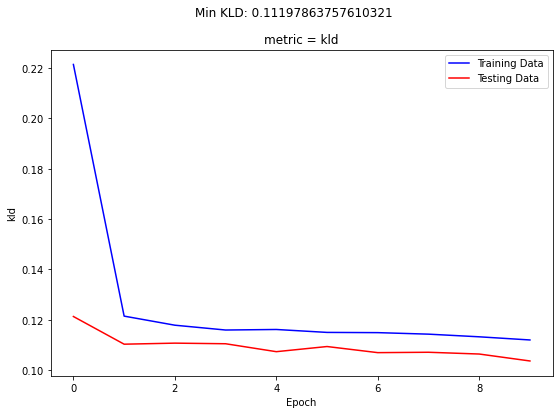

In [19]:
metric = 'kld'

tt.plot_training(e,t,metric)

## Metric Histogram

In [20]:


# i know the function still says test_klds, but now it calculates whatever metric you give it

metrics, metric_mean = tr.calculate_test_metrics(test_list=train_list[0:12],npdf=npdf,
                                        model=model,get_ypred_at_RT=get_ypred,
                                             metric = metric)

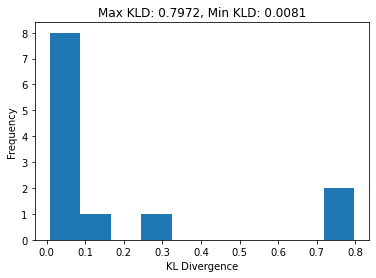

In [21]:
tt.plot_histogram(metrics,bins=10)

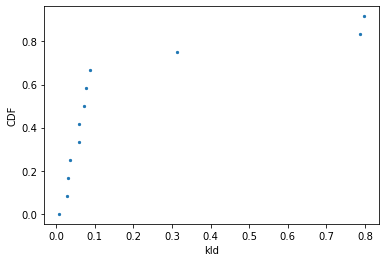

In [22]:
tt.plot_CDF(metrics)

## Plot Param Quantiles

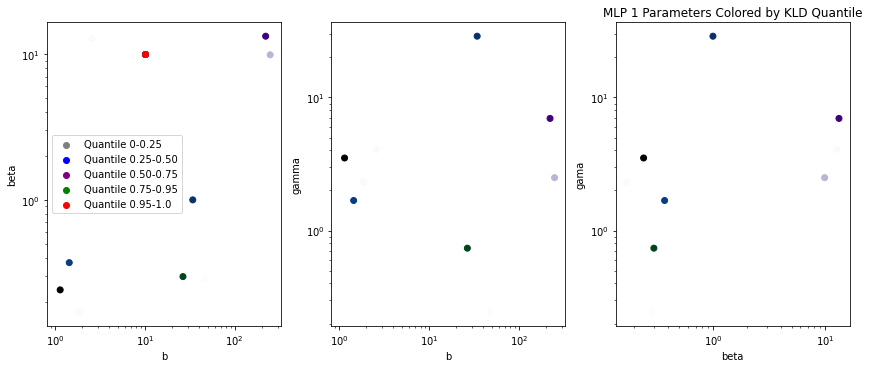

In [23]:
tt.plot_param_quantiles(metrics,train_list[0:12])

## Plot PMFs

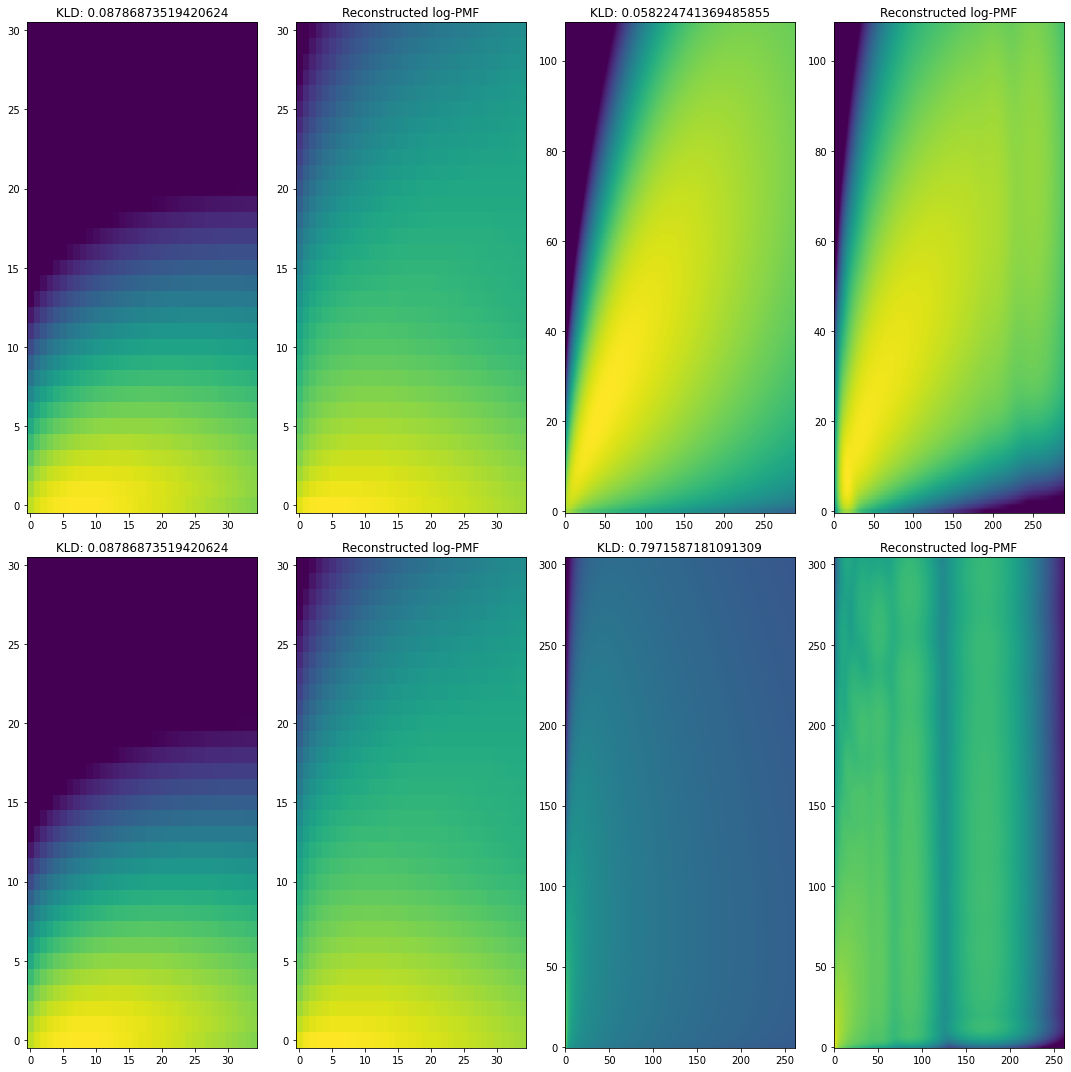

In [25]:
tt.plot_PMF_grid(file_list=train_list[0:10],npdf=npdf,nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred)

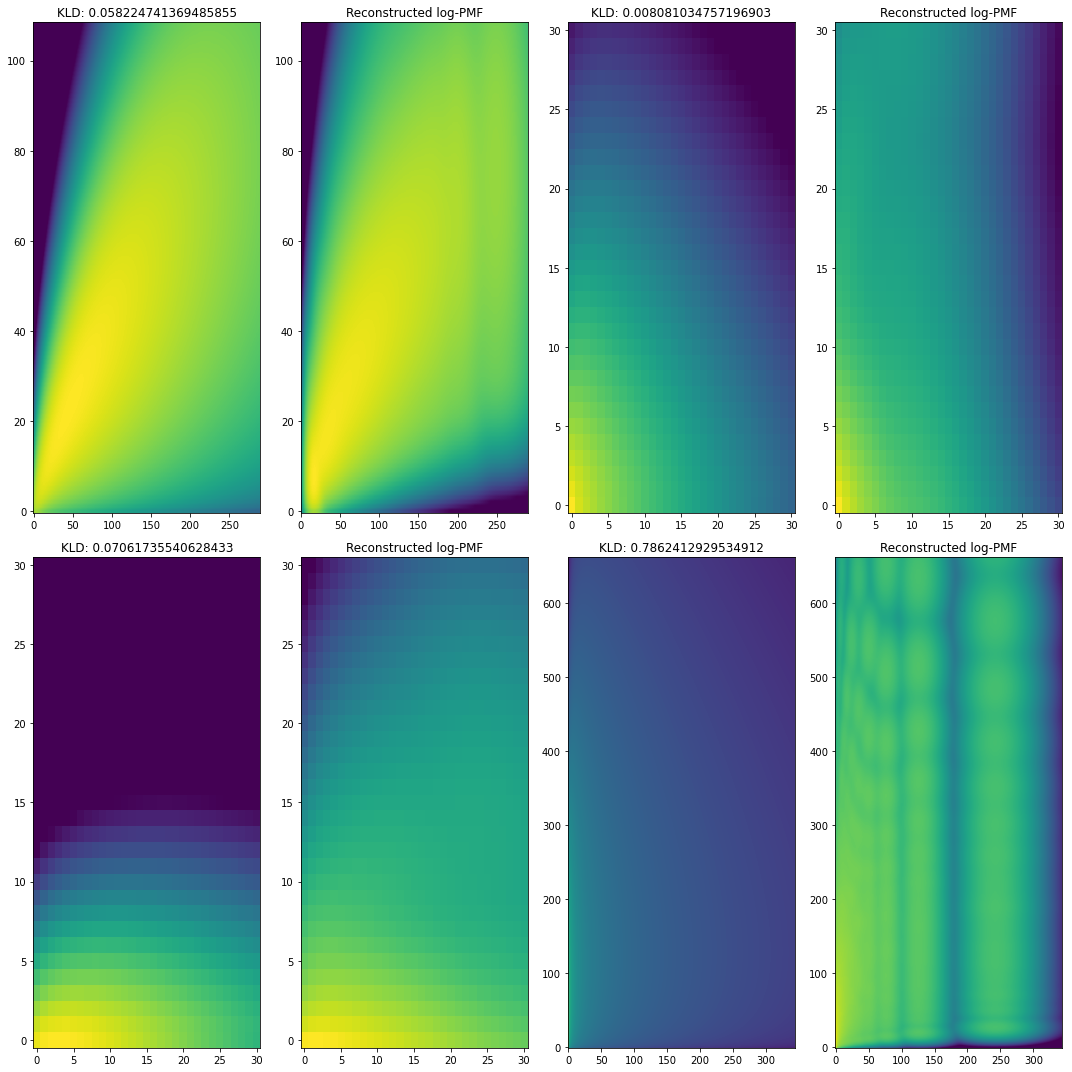

In [26]:
tt.plot_PMF_grid(file_list=train_list[0:10],npdf=npdf,nrows=2,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred)

In [27]:
def plot_PMF_grid(file_list,npdf,nrows,ncols,model,get_ypred_at_RT,kld=True,plot_points=True,log=True):
    
    p_list,y_list = tr.load_training_data(file_list)
#     rand = np.zeros(nrows*ncols) 
    
# #     print(p_list)
#     for i in range(nrows*ncols):
#         rand[i] = random.randint(0,len(y_list))
    rand_inds = np.random.choice(len(y_list),nrows*ncols,replace=False)
    y = []
    Y = []
    
    for r in rand_inds:
        r = int(r)
        y_pred = tr.get_predicted_PMF(p_list=p_list,
                                   npdf=npdf,position=r,model=model,get_ypred_at_RT = get_ypred_at_RT)
        
        y.append(y_list[r])
        Y.append(y_pred)
    
    Y = [Y_.detach().numpy() for Y_ in Y]
    y = [y_.detach().numpy() for y_ in y]
    
    Y = [Y_.reshape(y[i].shape) for i,Y_ in enumerate(Y)]

    fig, ax1 = plt.subplots(nrows=nrows, ncols=2*ncols, figsize=(15, 15))
    k = 0
#     print(rand_inds)
    j_num = np.arange(0,ncols*2,2)
    
    for i in range(nrows):
        for j in j_num:
            y_ = y[k]
            Y_ = Y[k]
            cm='viridis'
            
            vmin = np.minimum(y_.min(),Y_.min())
            vmax = np.maximum(y_.max(),Y_.max())
            print(vmin)
            if log:
                vmin = np.log10(vmin)
                vmax = np.log10(vmax)
                ax1[i,j].imshow(np.log10(y_).T,cmap=cm,aspect='auto',vmin=vmin,vmax=vmax)
                ax1[i,j+1].imshow(np.log10(Y_).T,cmap=cm,aspect='auto',vmin=vmin,vmax=vmax)
            else:
                ax1[i,j].imshow((y_).T,cmap=cm,aspect='auto',vmin=vmin,vmax=vmax)
                ax1[i,j+1].imshow((Y_).T,cmap=cm,aspect='auto',vmin=vmin,vmax=vmax)
            
            if plot_points:
                p__ = 10**p_list[rand_inds[k]]
                MU, VAR, STD, xmax = tr.get_moments(p__)
                GRID_nas,GRID_mat = generate_grid_affine(npdf,VAR,MU,p__,quantiles='PRESET')
                ax1[i,j+1].scatter(GRID_nas[:],GRID_mat[:],s=5,c='k')
            ax1[i,j].invert_yaxis()
            ax1[i,j].set_title('True log-PMF & basis locations')
            ax1[i,j+1].invert_yaxis()
            ax1[i,j+1].set_title('Reconstructed log-PMF')
            
            if kld == True:
                kld_ = -np.sum(y_.flatten()*np.log(Y_.flatten()/y_.flatten()))
                ax1[i,j].title.set_text(f'KLD: {kld_}')
            k = k + 1

        
    fig.tight_layout()

it would be nice to have these plotted in a deterministic order

8.425317e-09
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
1e-16
2.1155253e-15


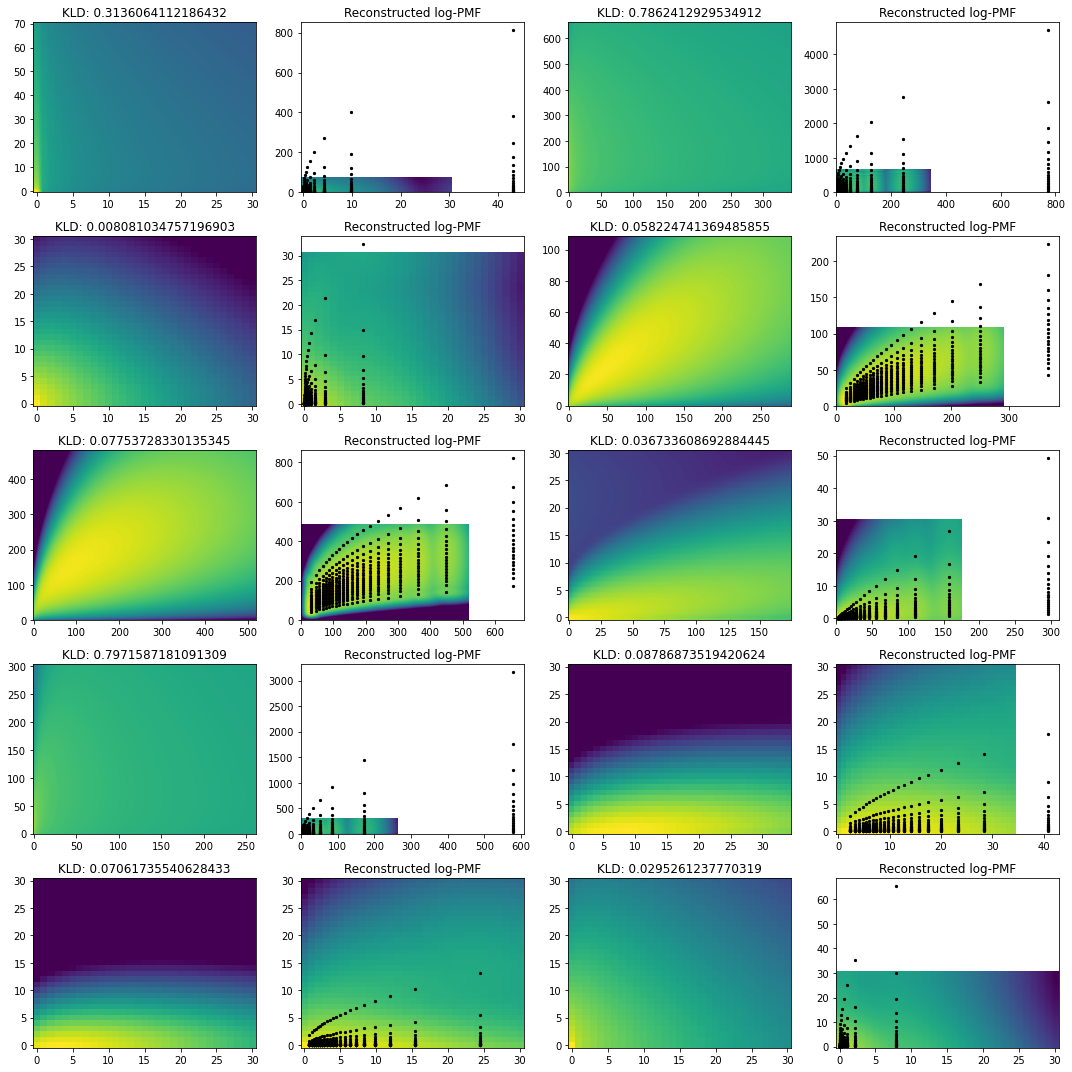

In [28]:
plot_PMF_grid(file_list=train_list[0:10],npdf=npdf,nrows=5,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred,log=True)

1e-16
1e-16
8.425317e-09
1e-16
1e-16
1e-16
1e-16
1e-16
2.1155253e-15
1e-16


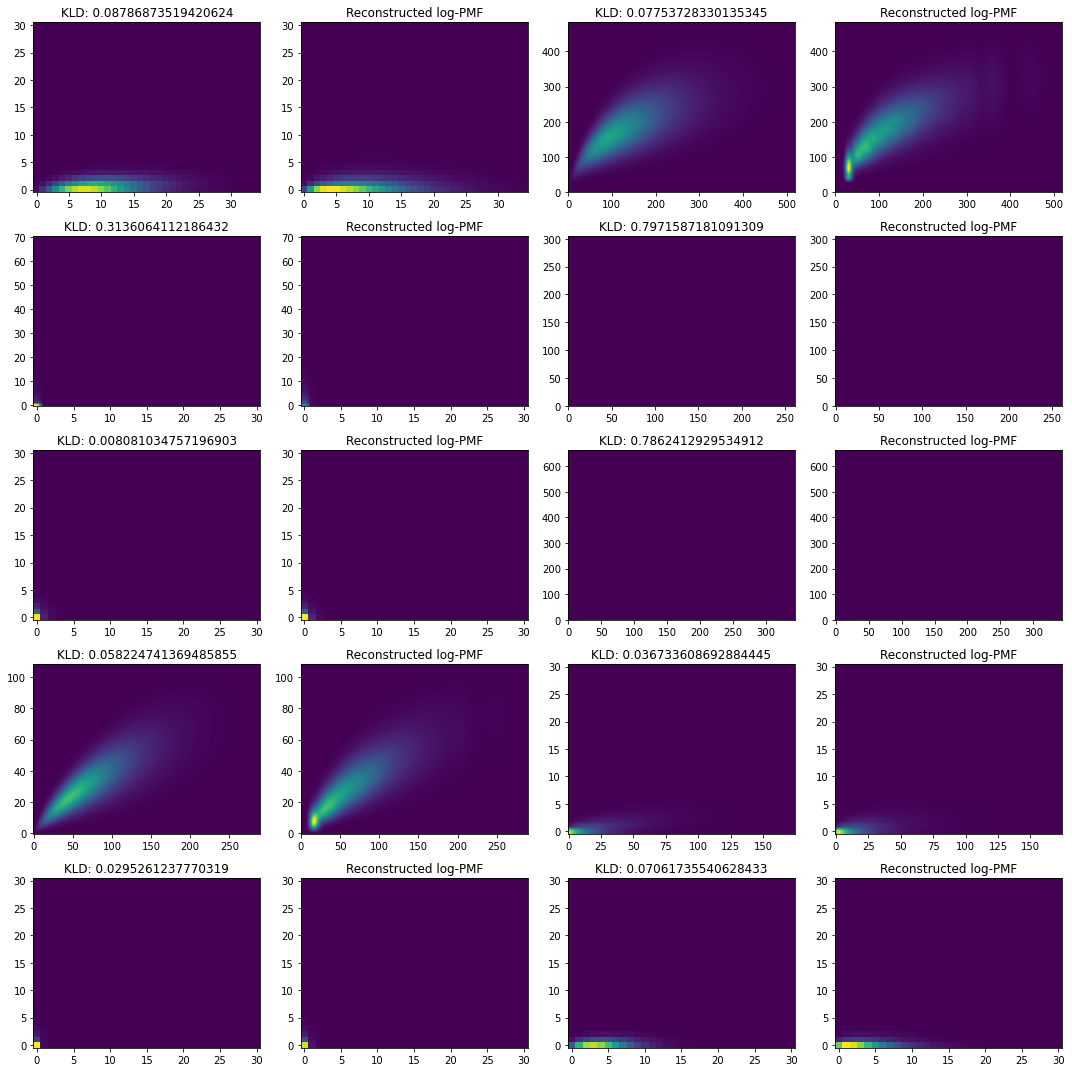

In [29]:
plot_PMF_grid(file_list=train_list[0:10],npdf=npdf,nrows=5,
                 ncols=2,model=model,get_ypred_at_RT=get_ypred,log=False,plot_points=False)

In [296]:
# train_list[0:10][0]

In [ ]:
params, ys = tr.load_training_data(train_list)

In [ ]:
# plot individual PMF

p_num = 21

params[p_num]

tt.plot_PMF(params[p_num:p_num+1],ys[p_num],npdf,model,get_ypred_at_RT_affine,metric)

To do : move in nnlsq code from `projects/gg220304_ml_cme_2d/learning_env.ipynb`